Import all the required libraries

In [10]:
import numpy as np
import heapq
import time as tm
import matplotlib.pyplot as plt

**Goal state:** The below segment represents goal State. Initial State is defined in general_search function. Currently we are using the goal state for 8 puzzle. The code also supports the implementation of 15 and 25 puzzle, we can do this by simply uncommenting the goal state for the desired puzzle.

In [11]:
# goal state is defined
goal_state = [[1,2,3],[4,5,6],[7,8,0]] #goal state for 8 puzzle
#goal_state = [[1,2,3,4],[5,6,7,8],[9,10,11,12],[13,14,15,0]] #goal state for 15 puzzle
#goal_state = [[1,2,3,4,5],[6,7,8,9,10],[11,12,13,14,15],[16,17,18,19,20],[21,22,23,24,0]] #goal state for 25 puzzle

General Search Algorithm:

*   This algorithm uses a priority queue (min-heap) for managing the frontier. Nodes in the frontier are expanded based on their total estimated cost (cost so far + heuristic estimate). It tracks visited states to avoid cycles and redundant paths.
*   The search continues until it finds a goal state or the frontier is empty, indicating that no solution exists. For each node expanded, it prints out the state and the respective costs, providing a trace of the algorithm’s decision-making process.


In [12]:
def general_search(initial_state, heuristic_choice):
    cost = 0  # Initial cost is zero
    depth = 0  # Initial depth is zero
    start_time = tm.time()  # Record the start time of the search
    root_node = (cost, depth, initial_state)  # Create the root node with cost, depth, and state
    priority_queue = [root_node]  # Initialize the queue with the root node
    visited_states = set()  # Track all visited states to prevent revisiting
    maximum_queue_size = 0  # Track the largest size of the queue
    nodes_expanded = 0  # Counter for the number of nodes expanded

    def queueing_function(queue, successors):
        nonlocal maximum_queue_size
        # Add new nodes to the priority queue
        for successor in successors:
            heapq.heappush(queue, successor)
        maximum_queue_size = max(maximum_queue_size, len(queue))  # Update maximum queue size
        return queue

    while priority_queue:
        current_node = heapq.heappop(priority_queue)  # Pop the node with the lowest cost
        print(f"\nExpanding node with g(n) = {int(current_node[0])} and h(n) = {int(current_node[1])}:")

        current_state = current_node[2]
        for row in current_state:
            print(row)
        nodes_expanded += 1
        visited_states.add(tuple(map(tuple, current_state)))  # Mark this state as visited

        if current_state == goal_state:  # Check if the current state is the goal state
            end_time = tm.time()
            execution_time = end_time - start_time
            print("\nGoal state reached!")
            return current_node[1], nodes_expanded, execution_time, maximum_queue_size

        # Generate successors and enqueue them
        priority_queue = queueing_function(priority_queue, generate_successors(current_node, heuristic_choice, visited_states))

    print("Failed to find a solution")  # If no solution is found
    return -1

**Misplaced Tiles:** The below function counts the number of tiles that are not in their goal position, excluding the blank tile (represented as 0).

In [13]:
def misplaced_tiles_heuristic(puzzle):
    misplaced = 0
    size = len(puzzle)

    for row in range(size):
        for col in range(size):
            expected_tile = row * size + col + 1
            current_tile = puzzle[row][col]

            # Check if the current tile is not the blank space (0) and is not in its correct position
            if current_tile != 0 and current_tile != expected_tile:
                misplaced += 1

    return misplaced

**Manhattan Distance**: This function calculates the total distance tiles need to move to reach their goal positions in terms of the grid's rows and columns.

In [14]:
def manhattan_distance_heuristic(puzzle):
    n = len(puzzle)
    manhattan_distance = 0

    for row in range(n):
        for col in range(n):
            # Get the value of the current tile, skip if it's the blank space
            tile = puzzle[row][col]
            if tile != 0:
                # Calculate the target row and column for the current tile
                target_row = (tile - 1) // n
                target_col = (tile - 1) % n
                # Calculate the Manhattan distance to the target position
                distance = abs(target_row - row) + abs(target_col - col)
                manhattan_distance += distance

    return manhattan_distance

**generate successors:** explores all possible moves from the current puzzle state by sliding the empty tile (denoted as 0) to adjacent positions. For each valid move, it creates a new puzzle configuration, checks if this new state has been visited, and if not, calculates its cost based on the selected heuristic. It then stores these potential states for further exploration. This function is crucial for navigating through the state space of the puzzle in the search algorithms.


In [15]:
def generate_successors(current_node, heuristic_type, visited_states):
    generated_states = []

    # Decompose the node into its components: cost, depth, and puzzle configuration
    current_cost = current_node[0]
    current_depth = current_node[1]
    puzzle_state = current_node[2]

    # Define possible moves: left, right, up, down
    moves = [(0, -1), (0, 1), (-1, 0), (1, 0)]

    # Locate the empty tile (0) in the puzzle
    empty_tile_position = None
    for row_index in range(len(puzzle_state)):
        for col_index in range(len(puzzle_state[row_index])):
            if puzzle_state[row_index][col_index] == 0:
                empty_tile_position = (row_index, col_index)
                break
        if empty_tile_position:
            break

    # Generate all possible child states by moving the empty tile
    for move in moves:
        new_row = empty_tile_position[0] + move[0]
        new_col = empty_tile_position[1] + move[1]
        if 0 <= new_row < len(puzzle_state) and 0 <= new_col < len(puzzle_state[0]):
            # Create a deep copy of the puzzle_state to modify without affecting the original
            new_puzzle = [list(row) for row in puzzle_state]

            # Swap the tile at the empty position with the tile at the target position
            new_puzzle[empty_tile_position[0]][empty_tile_position[1]], new_puzzle[new_row][new_col] = \
                new_puzzle[new_row][new_col], new_puzzle[empty_tile_position[0]][empty_tile_position[1]]

            # Convert the list of lists to a tuple of tuples for immutability
            new_puzzle_tuple = tuple(map(tuple, new_puzzle))


            # Check if the new state has not been visited and is not the same as the current state
            if new_puzzle_tuple not in visited_states and new_puzzle_tuple != tuple(map(tuple, puzzle_state)):
                generated_states.append((current_cost, current_depth + 1, new_puzzle))
                visited_states.add(new_puzzle_tuple)

    # Define cost functions based on the chosen heuristic
    heuristic_functions = {
        1: lambda state: state[0] + 1,
        2: lambda state: state[0] + 1 + misplaced_tiles_heuristic(state[2]),
        3: lambda state: state[0] + 1 + manhattan_distance_heuristic(state[2])
    }

    # Apply the appropriate cost function to each child state
    final_states = [(
        heuristic_functions[heuristic_type](state),
        state[1],
        state[2]
    ) for state in generated_states]

    return final_states

**main function:** serves as the entry point for the 8-Puzzle Solver application. It guides the user through the process of either choosing a default puzzle configuration or creating a custom one. After selecting the puzzle, the user is prompted to choose a search algorithm to solve the puzzle. The function then executes the chosen algorithm, displays the puzzle solution process including the depth, number of nodes expanded, maximum queue size, and computation time, and provides the final results.


In [16]:
def main():
    # Function to display a 2D puzzle matrix
    def display_matrix(matrix):
        for row in matrix:
            print(" ".join(map(str, row)))
        print()

    print("| Welcome to the 8-Puzzle Solver |")
    print('\n')
    print("Choose '1' for a default puzzle or '2' to create your own.")

    # User choice for default or custom puzzle
    choice = int(input("Enter choice: "))
    if choice == 1:
        default_puzzle = [[0, 1, 2], [4, 5, 3], [7, 8, 6]]  # Default 8-puzzle state
        #default_puzzle= [[0, 1, 2, 3],[4, 5, 6, 7],[8, 9, 10, 11],[12, 13, 14, 15]] #puzzle initial state for 15 puzzle
        #default_puzzle= [[0, 1, 2, 3, 4],[5, 6, 7, 8, 9],[10, 11, 12, 13, 14],[15, 16, 17, 18, 19],[20, 21, 22, 23, 24]] #puzzle initial state for 25 puzzle
        print("\nHere's the default 8-puzzle configuration:\n")
        display_matrix(default_puzzle)
        puzzle_to_solve = default_puzzle

    elif choice == 2:
        size = int(input("Enter puzzle size (3 for 8-puzzle, 4 for 15-puzzle, 5 for 25-puzzle): "))
        custom_puzzle = []
        print("Enter your puzzle rows, using '0' to represent the blank. Ensure all numbers are within the appropriate range for the puzzle size:")

        i = 0
        while i < size:
            row_input = input(f"Enter row {i + 1} (separate numbers with space): ").strip().split()
            row = [int(num) for num in row_input]
            if len(row) != size or any(num < 0 or num >= size * size for num in row):
                print(f"Invalid input. Please enter exactly {size} numbers from 0 to {size * size - 1}, separated by spaces.")
            else:
                custom_puzzle.append(row)
                i += 1

        print("\nYour custom puzzle configuration:\n")
        display_matrix(custom_puzzle)
        puzzle_to_solve = custom_puzzle

    print("Choose search algorithm:")
    print("1: Uniform Cost Search")
    print("2: A* with Misplaced Tile Heuristic")
    print("3: A* with Manhattan Distance Heuristic")
    algorithm_choice = int(input("Enter choice: "))

    # Perform the search on the selected puzzle with the chosen algorithm
    depth, nodes_expanded, exec_time, max_queue_size = general_search(puzzle_to_solve, algorithm_choice)

    print(f"\nResults:\nDepth: {depth}\nNodes Expanded: {nodes_expanded}\nMax Queue Size: {max_queue_size}\nTime: {exec_time:.6f} seconds")

if __name__ == "__main__":
    main()

| Welcome to the 8-Puzzle Solver |


Choose '1' for a default puzzle or '2' to create your own.
Enter choice: 1

Here's the default 8-puzzle configuration:

0 1 2
4 5 3
7 8 6

Choose search algorithm:
1: Uniform Cost Search
2: A* with Misplaced Tile Heuristic
3: A* with Manhattan Distance Heuristic
Enter choice: 1

Expanding node with g(n) = 0 and h(n) = 0:
[0, 1, 2]
[4, 5, 3]
[7, 8, 6]

Expanding node with g(n) = 1 and h(n) = 1:
[1, 0, 2]
[4, 5, 3]
[7, 8, 6]

Expanding node with g(n) = 1 and h(n) = 1:
[4, 1, 2]
[0, 5, 3]
[7, 8, 6]

Expanding node with g(n) = 2 and h(n) = 2:
[1, 2, 0]
[4, 5, 3]
[7, 8, 6]

Expanding node with g(n) = 2 and h(n) = 2:
[1, 5, 2]
[4, 0, 3]
[7, 8, 6]

Expanding node with g(n) = 2 and h(n) = 2:
[4, 1, 2]
[5, 0, 3]
[7, 8, 6]

Expanding node with g(n) = 2 and h(n) = 2:
[4, 1, 2]
[7, 5, 3]
[0, 8, 6]

Expanding node with g(n) = 3 and h(n) = 3:
[1, 2, 3]
[4, 5, 0]
[7, 8, 6]

Expanding node with g(n) = 3 and h(n) = 3:
[1, 5, 2]
[0, 4, 3]
[7, 8, 6]

Expanding node wi

This section sets up the environment and initializes configurations for solving the 8-puzzle using different heuristic search strategies. We define several typical puzzle configurations and specify three search heuristics. The code then performs searches on each puzzle using these heuristics, collects data on search depth, number of nodes expanded, execution time, and maximum queue size, and stores these metrics. The final part of the script includes functions for plotting the collected data, comparing the performance of the heuristics visually in terms of depth versus time and expanded nodes versus depth, enhancing our understanding of each heuristic's efficiency and effectiveness.


Streaming output truncated to the last 5000 lines.

Expanding node with g(n) = 232 and h(n) = 17:
[1, 2, 8]
[0, 7, 5]
[4, 3, 6]

Expanding node with g(n) = 232 and h(n) = 17:
[1, 2, 8]
[7, 6, 0]
[3, 4, 5]

Expanding node with g(n) = 232 and h(n) = 17:
[1, 6, 2]
[7, 3, 8]
[5, 0, 4]

Expanding node with g(n) = 232 and h(n) = 17:
[1, 7, 2]
[5, 3, 6]
[4, 0, 8]

Expanding node with g(n) = 232 and h(n) = 17:
[1, 7, 6]
[0, 2, 8]
[3, 4, 5]

Expanding node with g(n) = 232 and h(n) = 17:
[1, 7, 6]
[2, 8, 0]
[3, 4, 5]

Expanding node with g(n) = 232 and h(n) = 17:
[1, 7, 6]
[4, 3, 2]
[5, 0, 8]

Expanding node with g(n) = 232 and h(n) = 17:
[1, 7, 8]
[2, 3, 6]
[4, 0, 5]

Expanding node with g(n) = 232 and h(n) = 17:
[2, 0, 3]
[4, 6, 1]
[5, 8, 7]

Expanding node with g(n) = 232 and h(n) = 17:
[2, 0, 4]
[6, 1, 5]
[7, 3, 8]

Expanding node with g(n) = 232 and h(n) = 17:
[2, 0, 4]
[6, 8, 1]
[7, 3, 5]

Expanding node with g(n) = 232 and h(n) = 17:
[2, 0, 6]
[7, 4, 1]
[5, 3, 8]

Expanding node with g(n)

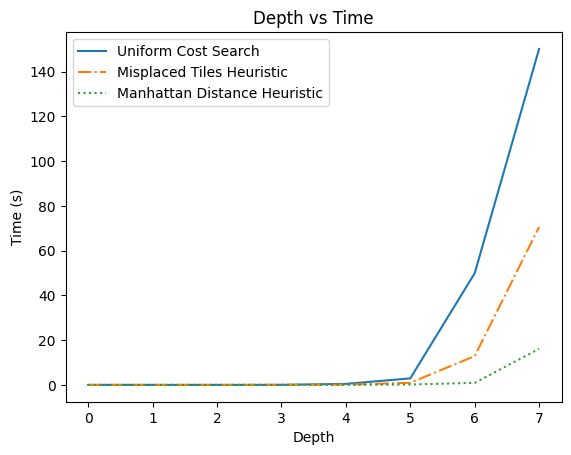

In [17]:
np.set_printoptions(suppress=True, formatter={'float_kind':'{:0.0f}'.format})

# Define puzzle configurations
puzzles = [
    [[1, 2, 3], [4, 5, 6], [7, 8, 0]],
    [[1, 2, 3], [4, 5, 6], [0, 7, 8]],
    [[1, 2, 3], [5, 0, 6], [4, 7, 8]],
    [[1, 3, 6], [5, 0, 2], [4, 7, 8]],
    [[1, 3, 6], [5, 0, 7], [4, 8, 2]],
    [[1, 6, 7], [5, 0, 3], [4, 8, 2]],
    [[7, 1, 2], [4, 8, 5], [6, 3, 0]],
    [[0, 7, 2], [4, 6, 1], [3, 5, 8]]
]

# Search strategies
heuristics = {
    'Uniform Cost Search': 1,
    'Misplaced Tiles Heuristic': 2,
    'Manhattan Distance Heuristic': 3
}

# Data storage
results = {name: np.zeros((len(puzzles), 4)) for name in heuristics}  # 4 metrics: depth, expansions, time, max_sizes

# Perform searches
for i, puzzle in enumerate(puzzles):
    for name, heuristic in heuristics.items():
        depth, expansions, time, max_queue = general_search(puzzle, heuristic)
        results[name][i] = [depth, expansions, time, max_queue]

linestyles = ['-', '--', '.']
# Output results
for name in heuristics:
    metrics = results[name]
    print(f"{name}:")
    print(f"Depth levels: {metrics[:, 0]}")
    print(f"Expanded nodes: {metrics[:, 1]}")
    print(f"Time taken: {[f'{time:.6f}' for time in metrics[:, 2]]}")
    print(f"Max queue size: {metrics[:, 3]}\n")

# Plotting functions
linestyles = ['-', '-.', ':']
def plot_data(x, y, title, xlabel, ylabel, legend_labels, linestyles):
    for i, label in enumerate(legend_labels):
        plt.plot(x, results[label][:, y], label=label, linestyle=linestyles[i])
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

# Display graphs
plot_data(np.arange(len(puzzles)), 2, "Depth vs Time", "Depth", "Time (s)", list(heuristics.keys()), linestyles)